<a href="https://colab.research.google.com/github/Satish-Kumar-1/Personal-Cancer-Diagnosis/blob/main/personalized_cancer_diagonsis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"satishkumar0912","key":"dc71fffb70f2b880d42ad5a523a03bfc"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c msk-redefining-cancer-treatment

 99% 167M/169M [00:09<00:00, 22.9MB/s]
100% 169M/169M [00:09<00:00, 18.8MB/s]


In [4]:
!unzip msk-redefining-cancer-treatment.zip

Archive:  msk-redefining-cancer-treatment.zip
  inflating: stage1_solution_filtered.csv.7z  
  inflating: stage2_sample_submission.csv.7z  
  inflating: stage2_test_text.csv.7z  
  inflating: stage2_test_variants.csv.7z  
  inflating: stage_2_private_solution.csv.7z  
  inflating: test_text.zip           
  inflating: test_variants.zip       
  inflating: training_text.zip       
  inflating: training_variants.zip   


In [5]:
!unzip training_variants.zip

Archive:  training_variants.zip
  inflating: training_variants       


# 1. Import important libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD

import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

import seaborn as sns

# 2. Load the dataset

In [7]:
data = pd.read_csv("/content/training_variants")
print('Number of data points: ', data.shape[0])
print('Number of features: ', data.shape[1])
print('Features: ', data.columns.values)
data.head()

Number of data points:  3321
Number of features:  4
Features:  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [8]:
data.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
!unzip training_text.zip

Archive:  training_text.zip
  inflating: training_text           


In [10]:
## Reading the text data

data_text = pd.read_csv("/content/training_text", sep = "\|\|", engine = "python", names = ["ID", "Text"], skiprows = 1 )
print("Number of data points: ", data_text.shape[0])
print("Number of features: ", data_text.shape[1])
print("Features: ", data_text.columns.values)
data_text.head()

Number of data points:  3321
Number of features:  2
Features:  ['ID' 'Text']


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [11]:
## Preprocessing the text

import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
# stop_words = set(stopwords.words('english'))

# def nlp_preprocessing(total_text, index, columns):
#     string = ""

#     total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)

#     total_text = re.sub('\s+', ' ', total_text)

#     total_text = total_text.lower()

#     for word in total_text.split():
#         if not word in stop_words:
#             string += word + " "

#     data_text[columns][index] = string

In [13]:
print(len(stopwords.words('english')))

179


In [14]:
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""

        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        total_text = re.sub('\s+',' ', total_text)
        total_text = total_text.lower()

        for word in total_text.split():
            if not word in stop_words:
                string += word + " "

        data_text.loc[column, index] = string



In [15]:
#text processing stage.
# start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['Text']) is str:
        nlp_preprocessing(row['Text'], index, 'Text')
    else:
        print("there is no text description for id:",index)
# print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

<ipython-input-14-2828ca736759>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_text.loc[column, index] = string
<ipython-input-14-2828ca736759>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_text.loc[column, index] = string
<ipython-input-14-2828ca736759>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfra

there is no text description for id: 1109


<ipython-input-14-2828ca736759>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_text.loc[column, index] = string
<ipython-input-14-2828ca736759>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_text.loc[column, index] = string
<ipython-input-14-2828ca736759>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfra

there is no text description for id: 1277


<ipython-input-14-2828ca736759>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_text.loc[column, index] = string
<ipython-input-14-2828ca736759>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_text.loc[column, index] = string
<ipython-input-14-2828ca736759>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfra

there is no text description for id: 1407


<ipython-input-14-2828ca736759>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_text.loc[column, index] = string
<ipython-input-14-2828ca736759>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_text.loc[column, index] = string
<ipython-input-14-2828ca736759>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfra

there is no text description for id: 1639


<ipython-input-14-2828ca736759>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_text.loc[column, index] = string
<ipython-input-14-2828ca736759>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_text.loc[column, index] = string
<ipython-input-14-2828ca736759>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfra

there is no text description for id: 2755


<ipython-input-14-2828ca736759>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_text.loc[column, index] = string
<ipython-input-14-2828ca736759>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_text.loc[column, index] = string
<ipython-input-14-2828ca736759>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newfra

In [16]:
# start_time = time.time

for index, row in data_text.iterrows():
    if type(row['Text']) is str:
        nlp_preprocessing(row['Text'], index, 'Text')

    else:
        print("There is no text description for id: ", index)

# print("Time took for preprocessing the text: ", time.time-start_time, "seconds")


There is no text description for id:  1109
There is no text description for id:  1277
There is no text description for id:  1407
There is no text description for id:  1639
There is no text description for id:  2755
There is no text description for id:  Text


In [17]:
data_text.head()

,ID,Text,0,1,2,3,4,5,6,7,...,3311,3312,3313,3314,3315,3316,3317,3318,3319,3320
0,0.0,Cyclin-dependent kinases (CDKs) regulate a var...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,Abstract Background Non-small cell lung canc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,Abstract Background Non-small cell lung canc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,Recent evidence has demonstrated that acquired...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,Oncogenic mutations in the monomeric Casitas B...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
data_text.Text[1]

" Abstract Background  Non-small cell lung cancer (NSCLC) is a heterogeneous group of disorders with a number of genetic and proteomic alterations. c-CBL is an E3 ubiquitin ligase and adaptor molecule important in normal homeostasis and cancer. We determined the genetic variations of c-CBL, relationship to receptor tyrosine kinases (EGFR and MET), and functionality in NSCLC.  Methods and Findings  Using archival formalin-fixed paraffin embedded (FFPE) extracted genomic DNA, we show that c-CBL mutations occur in somatic fashion for lung cancers. c-CBL mutations were not mutually exclusive of MET or EGFR mutations; however they were independent of p53 and KRAS mutations. In normal/tumor pairwise analysis, there was significant loss of heterozygosity (LOH) for the c-CBL locus (22%, n\u200a=\u200a8/37) and none of these samples revealed any mutation in the remaining copy of c-CBL. The c-CBL LOH also positively correlated with EGFR and MET mutations observed in the same samples. Using selec

In [19]:
result = pd.merge(data, data_text, on = 'ID', how = 'left')

In [20]:
result.head()

,ID,Gene,Variation,Class,Text,0,1,2,3,4,...,3311,3312,3313,3314,3315,3316,3317,3318,3319,3320
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
result = result.drop(result.iloc[:, 5:], axis = 1)

In [22]:
result[result.isnull().any(axis = 1)]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [23]:
result.loc[result['Text'].isnull(), 'Text'] = result['Gene'] + ' ' + result['Variation']

In [24]:

result[result['ID'] == 1109]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,FANCA S1088F


In [25]:
result.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


# Test, Train and Cross Validation Split


In [26]:
# Splitting the data into train, test, and cv

y_true = result['Class'].values

result.Gene = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# x = result.drop(result['Class'], axis  = 1)
# print(result.head())
x_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify = y_true, test_size = 0.2)
train_df, cv_df, y_train, y_cv = train_test_split(x_train, y_train, stratify = y_train, test_size = 0.2)


In [27]:
x_train.head()

,ID,Gene,Variation,Class,Text
3100,3100,RAC1,Q61R,7,Mutational hotspots indicate selective pressur...
1215,1215,PIK3CA,C378R,2,"PIK3CA, encoding the p110A catalytic subunit o..."
2858,2858,BRCA2,D2665G,5,Mutation screening of the breast and ovarian c...
2598,2598,BRCA1,V1809F,1,Abstract The BRCA1 gene from individuals at ...
802,802,ERBB4,E836K,7,Tyrosine phosphorylation is important in signa...


In [28]:
print('Number of data points in train data: ', train_df.shape[0])
print('Number of data points in test data: ', test_df.shape[0])
print('Number of data points in cross validation data: ', cv_df.shape[0])


Number of data points in train data:  2124
Number of data points in test data:  665
Number of data points in cross validation data:  532


In [29]:
-train_df['Class'].value_counts().values

array([-609, -439, -363, -289, -176, -155,  -57,  -24,  -12])

In [31]:
# print(np.round((train_class_distribution.values[1]/train_df.shape[0]*100), 3))

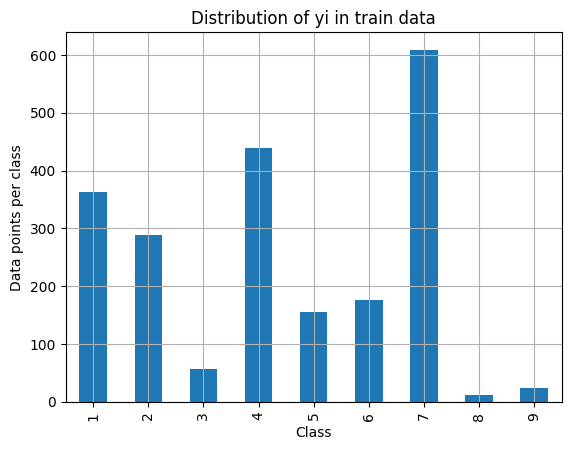

Number of data points in class 7 : 609 (28.672) %
Number of data points in class 4 : 439 (20.669) %
Number of data points in class 1 : 363 (17.09) %
Number of data points in class 2 : 289 (13.606) %
Number of data points in class 6 : 176 (8.286) %
Number of data points in class 5 : 155 (7.298) %
Number of data points in class 3 : 57 (2.684) %
Number of data points in class 9 : 24 (1.13) %
Number of data points in class 8 : 12 (0.565) %


In [32]:
# Distribution of y_i in train, test, cv datasets
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind = 'bar')
plt.xlabel('Class')
plt.ylabel('Data points per class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print(f'Number of data points in class {i+1} : {train_class_distribution.values[i]} ({np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3)}) %')

In [ ]:
my_colors = 'rgbkymc'
test_class_distribution.plot(kind = 'bar')
plt.xlabel('Class')
plt.ylabel('Data points per class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print(f'Number of data points in class {i+1} : {test_class_distribution.values[i]} ({np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3)} %)')

In [ ]:
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind = 'bar')
plt.xlabel('Class')
plt.ylabel('Data points per class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print(f'Number of data points in class {i+1} : {cv_class_distribution.values[i]} ({np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3)}) %')

# Prediction using a random model

In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)

    A = (((C.T)/(C.sum(axis = 1))).T)

    B = (C/C.sum(axis = 0))

    labels = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize = (20, 7))
    sns.heatmap(C, annot = True, cmap = 'YlGnBu', fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted class')
    plt.ylabel('Original class')
    plt.show()

    print("-"*20, "Precision matrix (column sum = 1)", "-"*20)
    plt.figure(figsize = (20, 7))
    sns.heatmap(B, annot = True, cmap = 'YlGnBu', fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted class')
    plt.ylabel('Original class')
    plt.show()

    print("-"*20, "Recall matrix (Row sum = 1)", "-"*20)
    plt.figure(figsize = (20, 7))
    sns.heatmap(A, annot = True, cmap = 'YlGnBu', fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted class')
    plt.ylabel('Original class')
    plt.show()

In [ ]:
random_values = np.random.rand(1,9)
cv = (random_values/sum(sum(random_values)))[0]
print(cv)

In [ ]:
sum(random_values)

In [ ]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)


# Univariate Analysis

In [ ]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()

    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()

    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class
            # 2470  2470  BRCA1                S1715C      1
            # 2486  2486  BRCA1                S1841R      1
            # 2614  2614  BRCA1                   M1R      1
            # 2432  2432  BRCA1                L1657P      1
            # 2567  2567  BRCA1                T1685A      1
            # 2583  2583  BRCA1                E1660G      1
            # 2634  2634  BRCA1                W1718L      1
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]

            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):

    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()

    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [ ]:
# def get_gv_fea_dict(alpha, feature, df):
#     value_count = train_df[feature].value_counts()
#     gv_dict =  dict()

#     for i, denominator in value_count.items():
#         vec = []

#         for k in range(1, 10):
#             cls_cnt = train_df.loc[(train_df['Class'] == k) & (train_df[feature] == i)]
#             vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

#         gv_dict[i] = vec
#     return gv_dict

In [ ]:
# def get_gv_feature(alpha, feature, df):
#     gv_dict = get_gv_fea_dict(alpha, feature, df)

#     value_count = train_df[feature].value_counts()

#     gv_fea = []

#     for index, row in df.iterrows():
#         if row[feature] in dict(value_count).keys():
#             gv_fea.append(gv_dict[row[feature]])

#         else:
#             gv_fea.append([1/9, 1/9, 1/9, 1/9,  1/9, 1/9, 1/9, 1/9, 1/9])

#     return gv_fea

In [ ]:
unique_genes = train_df['Gene'].value_counts()
print("Number of Unique Genes: ", unique_genes.shape[0])

print(unique_genes.head(10))

In [ ]:
print("Ans: There are ",unique_genes.shape[0], "different categories of genes in the train data and they are distributed as follows",)
s = sum(unique_genes.values)
h = unique_genes.values/s

plt.plot(h, label = "Histogram of genes")
plt.xlabel('Index of gene')
plt.ylabel('Number of occurances')
plt.legend()
plt.grid()
plt.show()

In [ ]:
c = np.cumsum(h)
plt.plot(c, label = 'Cumulative distribution of genes')
plt.grid()
plt.legend()
plt.show()

In [ ]:
alpha = 1

train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df ))

test_gene_feature_reponseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))

cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [ ]:
print("train_gene_feature_responseCoding is converted feature using coding method. The shape of gene  features: ", train_gene_feature_responseCoding.shape)

In [ ]:
gene_vectorizer = CountVectorizer()

train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.fit_transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.fit_transform(cv_df['Gene'])

In [ ]:
cv_gene_feature_onehotCoding.shape

In [ ]:
train_df['Gene'].head()

In [ ]:
gene_vectorizer.get_feature_names_out()

In [ ]:
print("train_gene_feature_onehotencoding is converted feature using one hot encoding method. the shape of gene feature: ", train_gene_feature_onehotCoding.shape)

In [ ]:
alpha = [10**x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is: ",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

